In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import sys

In [61]:
avg = xr.open_mfdataset(os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_avg_00??.nc'))
his = xr.open_mfdataset(os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_his_00??.nc')).sel(ocean_time='2015')
dl = xr.open_dataset(os.path.join(os.environ.get('rawdir'),'hre10_nudg_slow','ocean_his_0002.nc'))
ds = xr.open_dataset(os.path.join(os.environ.get('rawdir'),'hre10_nudg_slow','2h.nc'))

In [67]:
avg.isel(s_rho=22,xi_rho=155,eta_rho=300,xi_u=155,eta_u=300,xi_v=155,eta_v=300,s_w=23).

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan])

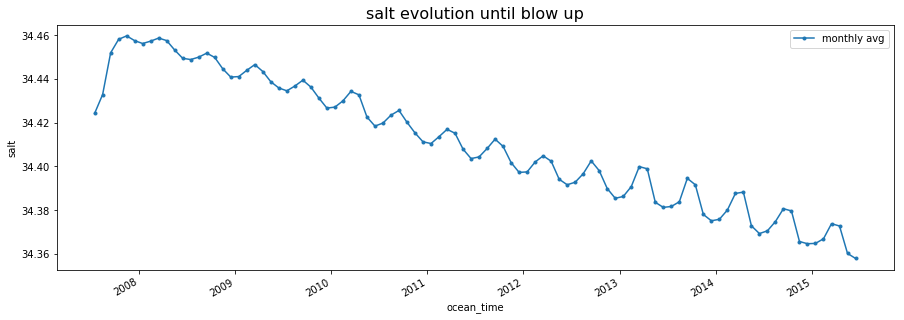

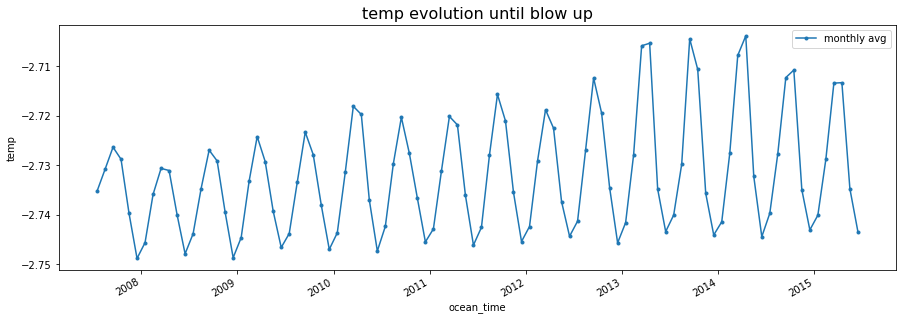

In [82]:
plt.close()
for var in ['salt','temp']:
    plt.figure(figsize=(15,5))
    avg.isel(s_rho=23,xi_rho=156,eta_rho=301)[var][6:].plot(label='monthly avg',marker='.')
    plt.legend()
    plt.title(var +' evolution until blow up',fontsize=16)
    plt.show()

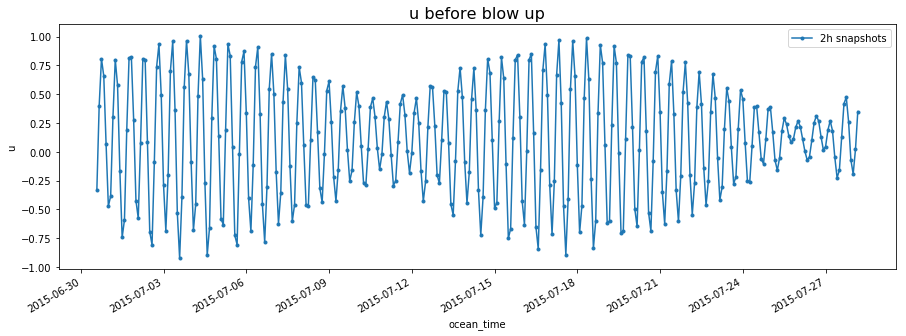

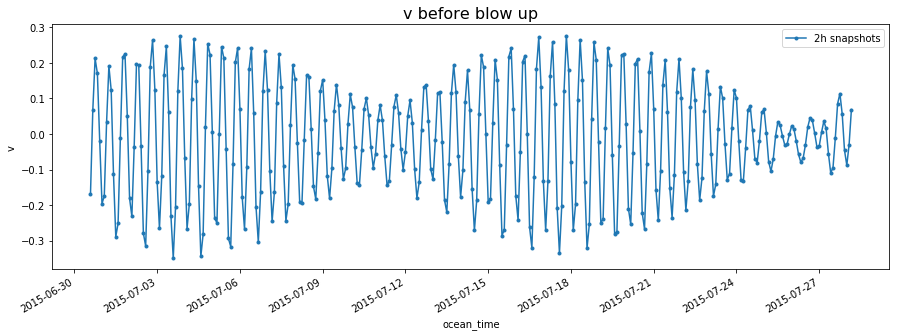

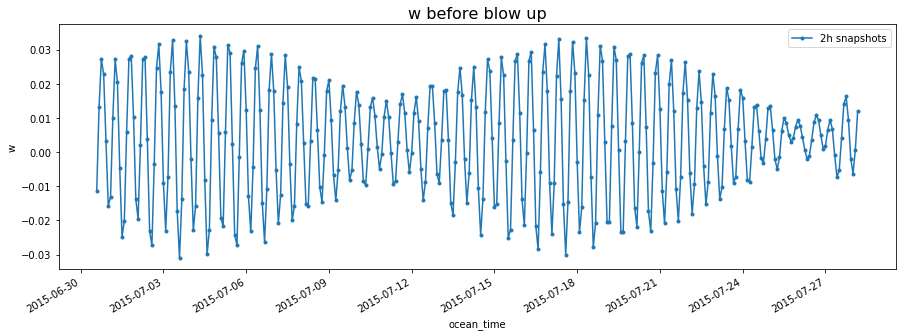

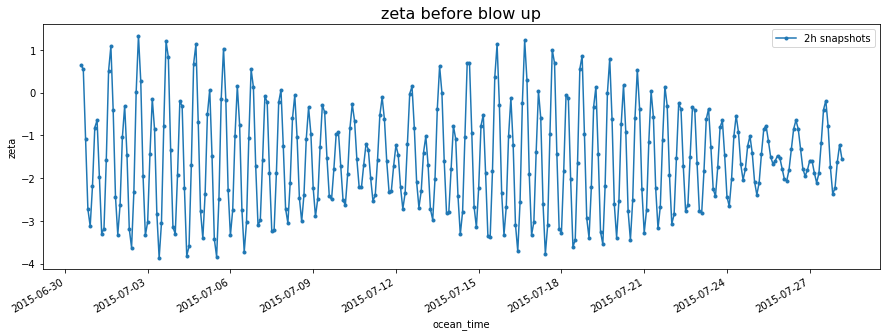

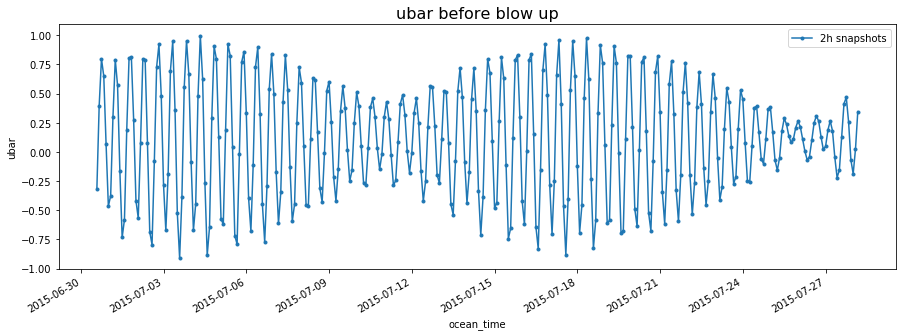

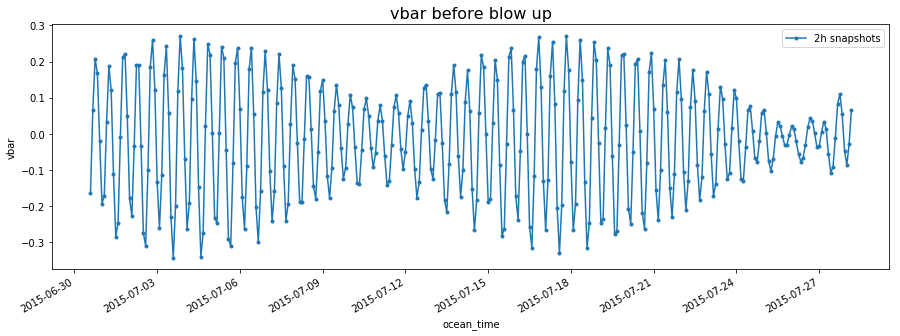

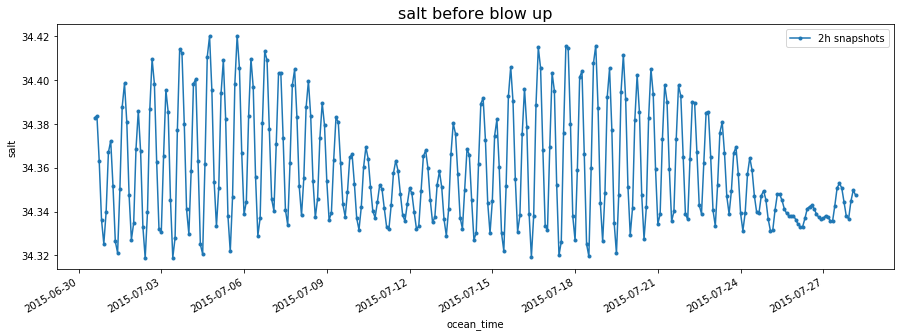

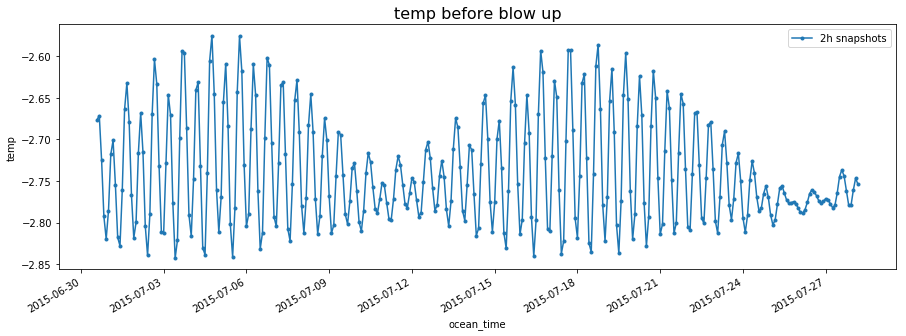

In [78]:
plt.close()
for var in ['u','v','w','zeta','ubar','vbar','salt','temp']:
    plt.figure(figsize=(15,5))
    dl.isel(s_rho=22,xi_rho=156,eta_rho=301,xi_u=156,eta_u=301,xi_v=156,eta_v=301,s_w=23)[var].plot(label='2h snapshots',marker='.')
    plt.legend()
    plt.title(var+' before blow up',fontsize=16)
    plt.show()

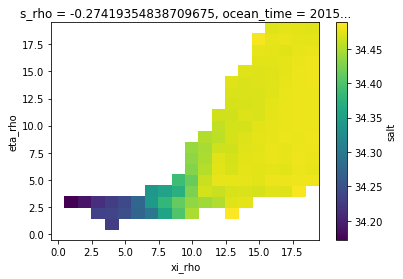

In [75]:
from ipywidgets import interact
plt.close()
avg.salt.isel(xi_rho=slice(148,168),eta_rho=slice(299,319),s_rho=22)[-1].plot()
plt.show()

In [192]:
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_stable_grd.nc')
grd = xr.open_dataset(grd_path)

In [193]:
grd_path = os.path.join(os.environ.get('rawdir'),'hre10_nudg_slow','waom10_robust_grd.nc')
grd_new = xr.open_dataset(grd_path)

<IPython.core.display.Javascript object>


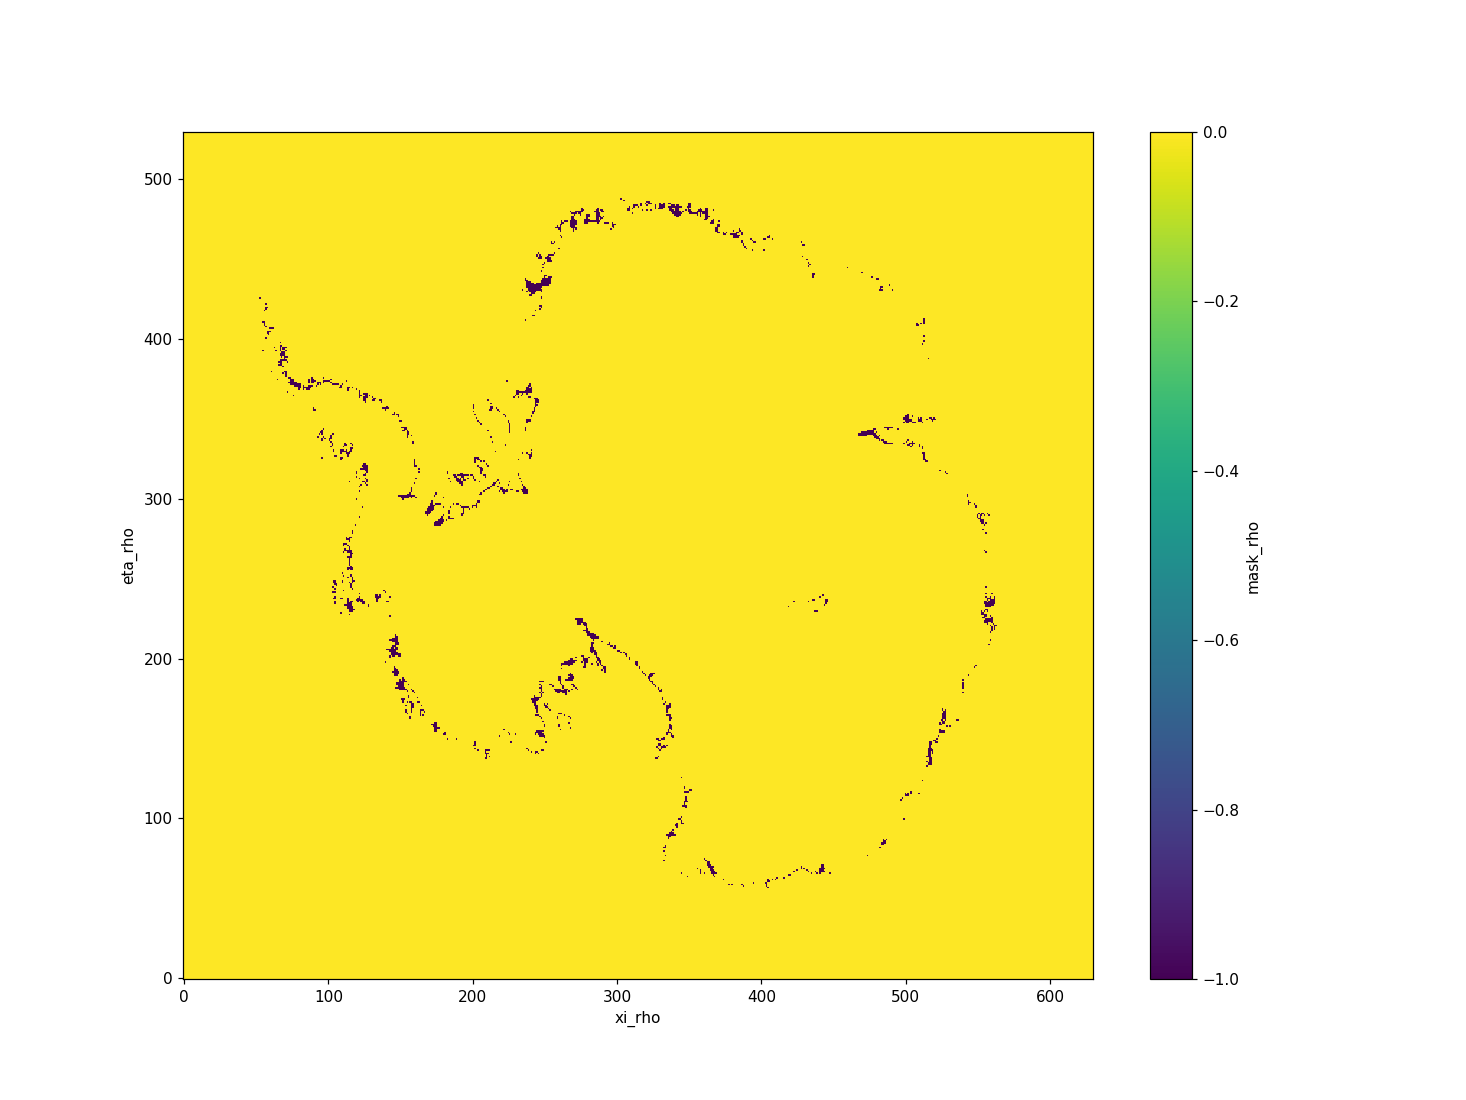

In [195]:
plt.close()
(grd_new.mask_rho-grd.mask_rho).plot(size=10)
plt.show()

In [196]:
plt.close()
(grd.h + grd.zice + dl.zeta.mean('ocean_time')).plot(size=7,vmax=20)
plt.title('WCT with mean zeta')
plt.show()

NameError: name 'dl' is not defined

<IPython.core.display.Javascript object>


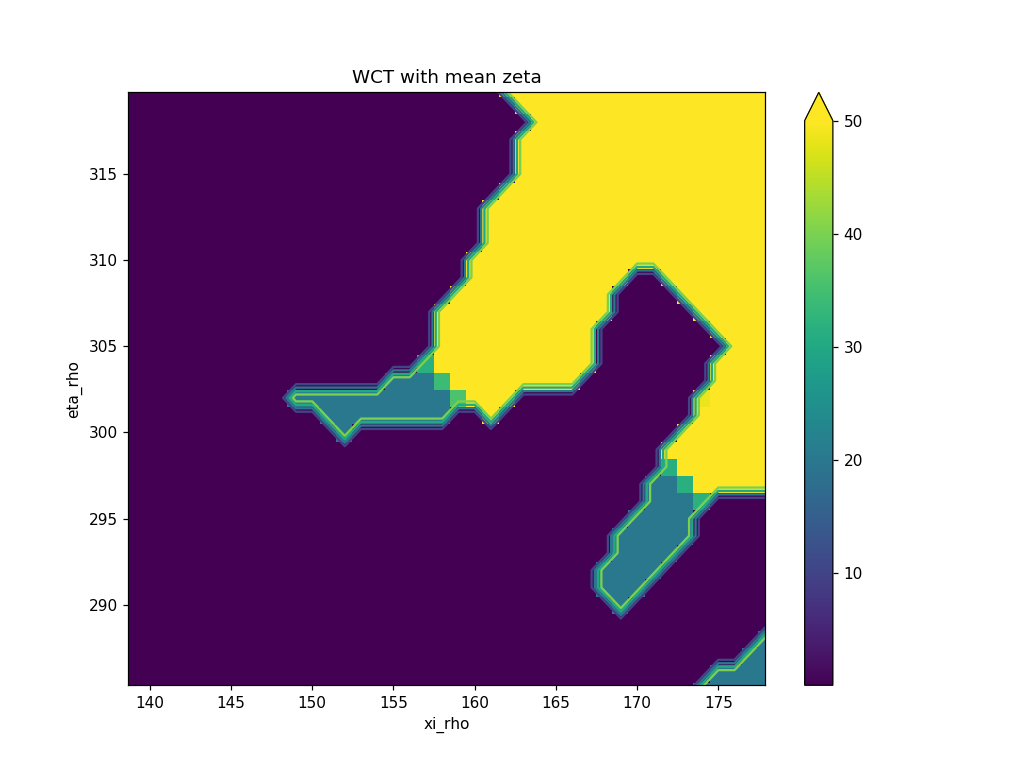

In [175]:
plt.close()
(grd.h+grd.zice).plot(size=7,vmax=50)
grd.mask_rho.plot.contour()
plt.title('WCT with mean zeta')
plt.show()

<IPython.core.display.Javascript object>


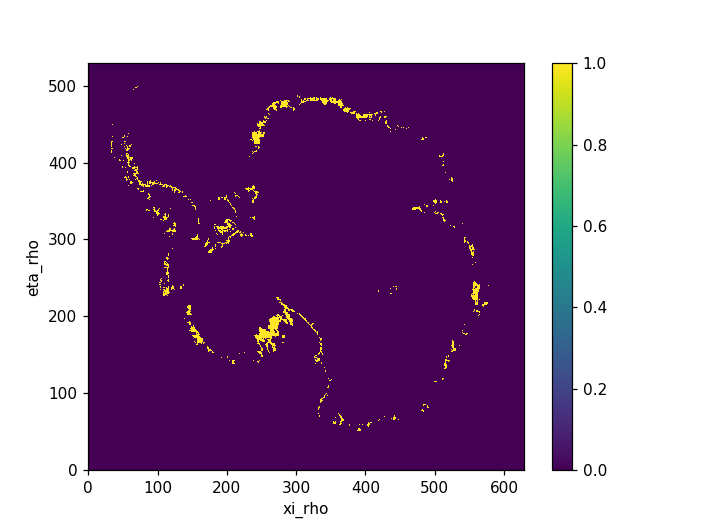

In [183]:
mask_shallow=((grd.h+grd.zice)<=100) & (grd.mask_rho == 1)
plt.close()
mask_shallow.plot()
plt.show()

In [182]:
grd.h.values[mask_shallow] = grd.zice.values[mask_shallow]*-1 + 50

In [185]:
from features.log_progress import log_progress
#from features.mask_roms_uvp import uvp_masks
import numpy as np
import bathy_smoother

rx0in = 0.1
max_iter = 150

def smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix,rounds):
    """
    This program use the Mellor-Ezer-Oey method (Mellor et al., 1994).
    The bathymetry is optimized for a given rx0 factor by doing a sequence
    of increase/decrease at adjacent cells.

    Usage:
    RetBathy, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix)

    ---MSK(eta_rho,xi_rho) is the mask of the grid
         1 for sea
         0 for land
    ---Hobs(eta_rho,xi_rho) is the raw depth of the grid
    ---rx0max is the target rx0 roughness factor
    ---AreaMatrix(eta_rho,xi_rho) is the matrix of areas at
       rho-points.
    """

    RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(Hobs,MSK)
    print('Old Max Roughness value is: ', RoughMat.max())
    
    eta_rho, xi_rho = Hobs.shape

    ListNeigh = np.array([[1, 0],
                          [0, 1],
                          [-1, 0],
                          [0, -1]])

    RetBathy = Hobs.copy()

    HmodifVal = 0
    TheMultiplier = (1 - rx0max) / (1 + rx0max)
    tol = 0.000001
    ValueFct = 0

    for round in log_progress(range(rounds),name='steps'):
        IsFinished = 1
        for iEta in range(eta_rho):
            for iXi in range(xi_rho):
                if (MSK[iEta, iXi] == 1):
                    Area = AreaMatrix[iEta, iXi]
                    for ineigh in range(4):
                        iEtaN = iEta + ListNeigh[ineigh,0]
                        iXiN = iXi + ListNeigh[ineigh,1]
                        if (iEtaN <= eta_rho-1 and iEtaN >= 0 and iXiN <= xi_rho-1 \
                            and iXiN >= 0 and MSK[iEtaN,iXiN] == 1):
                            AreaN = AreaMatrix[iEtaN,iXiN]
                            LowerBound = RetBathy[iEtaN,iXiN] * TheMultiplier
                            if ((RetBathy[iEta,iXi] - LowerBound) < -tol):
                                IsFinished = 0
                                h = (TheMultiplier * RetBathy[iEtaN,iXiN] - RetBathy[iEta,iXi]) \
                                         / (AreaN + TheMultiplier * Area)
                                RetBathy[iEta,iXi] = RetBathy[iEta,iXi] + AreaN * h
                                RetBathy[iEtaN,iXiN] = RetBathy[iEtaN,iXiN] - Area * h
                                HmodifVal = HmodifVal + abs(h)
                                ValueFct = ValueFct + abs(h) * (Area + AreaN)
        
        if (IsFinished == 1):
            break
            
    H = AreaMatrix * Hobs * MSK
    TheBathymetry1 = H.sum()
    H = AreaMatrix * RetBathy * MSK
    TheBathymetry2 = H.sum()
    DeltaBathymetry = TheBathymetry1 - TheBathymetry2
    print('DeltaBathymetry = ', DeltaBathymetry)

    RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(RetBathy,MSK)
    print('New Max Roughness value is: ', RoughMat.max())
    
    return RetBathy, HmodifVal, ValueFct

Area = 1/(grd.pm*grd.pn)

wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_shallow.values,grd.h.values+grd.zice.values,rx0in,Area.values,max_iter)

bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_shallow.values,grd.h.values,rx0in,Area.values,max_iter)

Old Max Roughness value is:  0.300000008971


VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  0.0
New Max Roughness value is:  0.100000009612
Old Max Roughness value is:  0.350455062513


VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  0.03125
New Max Roughness value is:  0.100000012222


In [186]:
grd.zice.values=-bed+wct
grd.h.values=bed

<IPython.core.display.Javascript object>


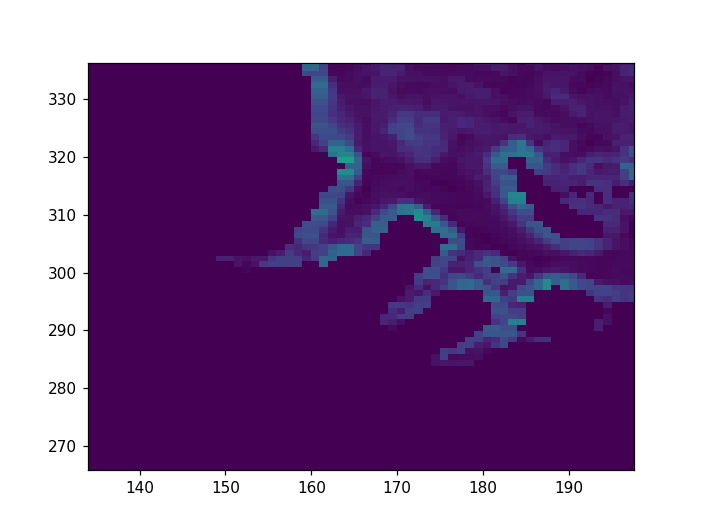

In [189]:
RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(grd.h.values,grd.mask_rho.values)
plt.close()
plt.pcolormesh(RoughMat)
plt.show()

In [190]:
from features.mask_roms_uvp import uvp_masks
grd.mask_u.values,grd.mask_v.values,grd.mask_psi.values = uvp_masks(grd.mask_rho.values)

<IPython.core.display.Javascript object>


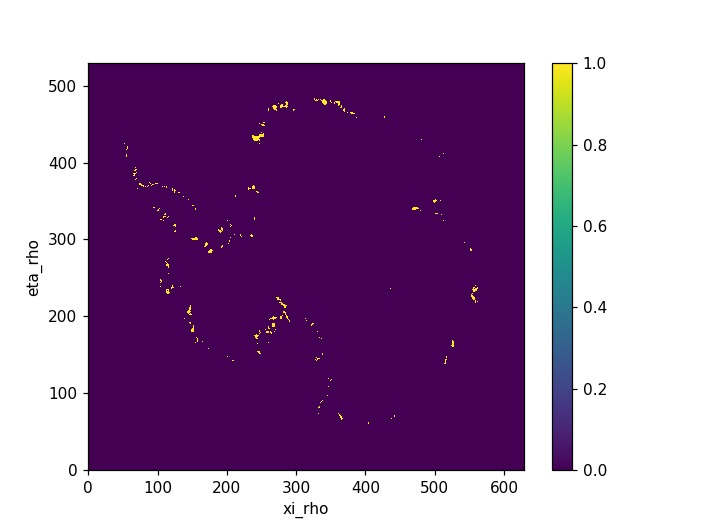

In [169]:
mask_shallow = ((grd.h+grd.zice)<=20) & (grd.mask_rho==1)
plt.close()
mask_shallow.plot()
plt.show()

In [165]:
h_new = grd.h.copy()

In [171]:
grd.mask_rho.values[mask_shallow]=0

In [191]:
grd_path = os.path.join(os.environ.get('rawdir'),'hre10_nudg_slow','grd.nc')
grd.to_netcdf(grd_path)